In [ ]:
import os
import re
import gc
import string
import unicodedata
import operator
import numpy as np
import pandas as pd

from sklearn import utils
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
# from keras import initializers, regularizers, constraints
from keras.layers import Activation
from keras.engine.topology import Layer
from keras.layers import (Input, Embedding, SpatialDropout1D, Bidirectional, Flatten, Dense) #CuDNNLSTM
from keras.initializers import glorot_normal, orthogonal
from keras.models import Model
from keras.callbacks import (EarlyStopping, ModelCheckpoint,
                             ReduceLROnPlateau)

from tqdm import tqdm
tqdm.pandas()


In [ ]:
df_train = pd.read_csv(os.path.join('','df_train.csv'))
df_train.head()

,Unnamed: 0,question_text,target
0,708878,Does provocative psychotherapy work ?,0
1,719951,Why do alot of Quoran finish their answers wi...,1
2,776092,Would Democrats vote for a gay Presidential ca...,1
3,415500,How can I find myself ? I lost my way along th...,0
4,79880,After failing to make Philippines and Vietnam ...,0


In [ ]:
df_test = pd.read_csv(os.path.join('','df_test.csv'))
df_test.head()
df_test.shape

(32000, 3)

In [ ]:
def tokenize(df_text, max_features):
    # preprocess
    df_text = df_text.progress_apply(preprocess)
    # tokenizer
    tokenizer = Tokenizer(
        num_words=max_features,
        filters='',
        lower=False,
        split=' ')
    # fit to data
    tokenizer.fit_on_texts(list(df_text))
    # tokenize the texts into sequences
    sequences = tokenizer.texts_to_sequences(df_text)
    return sequences, tokenizer



In [ ]:
import tensorflow_hub as hub

In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/2"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)



In [ ]:
def build_model(bert_layer, max_len=128):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(300, activation='sigmoid')(clf_output)
    out1 = Dense(1,activation='sigmoid')(out)
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out1)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
!pip install bert-for-tf2

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from bert import bert_tokenization
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(df_train.question_text.values, tokenizer, max_len=100)
test_input = bert_encode(df_test.question_text.values, tokenizer, max_len=100)
train_labels = df_train.target.values

In [ ]:
model = build_model(bert_layer, max_len=100)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 333579265   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
#checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    epochs=3,
    batch_size=25
)

Epoch 1/3
5120/5120 [==============================] - 8414s 2s/step - loss: 0.2253 - accuracy: 0.9156
Epoch 2/3
5120/5120 [==============================] - 8408s 2s/step - loss: 0.1437 - accuracy: 0.9504
Epoch 3/3
5120/5120 [==============================] - 8404s 2s/step - loss: 0.0807 - accuracy: 0.9744


In [ ]:
preds = model.predict(test_input,batch_size = 25)

In [ ]:
y_test = df_test['target']

In [ ]:
def line_search_f1_score(y_score, y_test):
    max_f1_score = 0
    opt_threshold = 0
    for threshold in [i*0.01 for i in range(100)]:
        y_preds = y_score > threshold
        score = f1_score(y_preds, y_test)
        if max_f1_score < score:
            max_f1_score = score
            opt_threshold = threshold
    return max_f1_score, opt_threshold

In [ ]:
max_f1_score, threshold = line_search_f1_score(preds,y_test)
print(max_f1_score, threshold)

0.9272311212814646 0.18


In [ ]:
predictions = [1 if x > 0.18 else 0 for x in preds]

In [ ]:
from sklearn.metrics import f1_score,accuracy_score,precision_score,precision_recall_curve, confusion_matrix

0.92546875


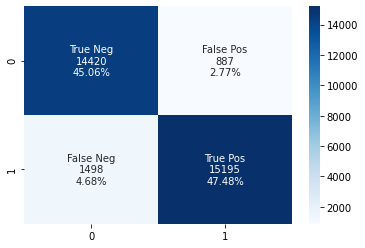

In [ ]:
cf_matrix = confusion_matrix(predictions, y_test)

import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

print(accuracy_score(predictions, y_test))

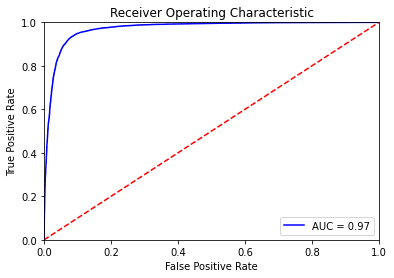

In [ ]:
import sklearn.metrics as metrics
#preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

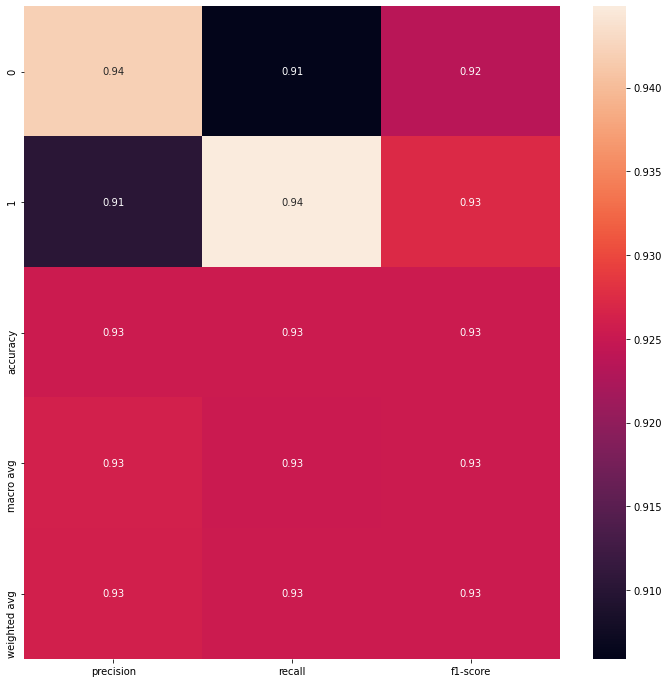

In [ ]:
from sklearn.metrics import classification_report

clf_report = classification_report(y_test,
                                   predictions,
                                   labels=[0,1],
                                   output_dict=True)

fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,ax=ax,square = False)